<a href="https://colab.research.google.com/github/hindhammad24/Computer-Vision-Project/blob/main/computervisionproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plantify** -  Plant Health Detector


**By Hind Hammad and Manmeet Sagri**

**Clasification**: Assigns one label to the whole image for example "This plant is diseased.”


**Project Overview**

This project, Plantify or Plant Health Detector, applies computer vision to classify plant images as healthy or diseased.
The goal is to help everyday gardeners identify early signs of plant disease before visible damage becomes severe.
By fine-tuning a YOLOv8 classification model, we aim to train a system that recognizes general plant health from photos taken in outdoor garden conditions.

**Problem**

Many home gardeners struggle to detect early plant stress or infection, which often leads to preventable plant loss.
Our model analyzes plant photos and classifies them into two categories, Healthy and Diseased, to support better plant care and timely action.

**Users**

The primary users are home gardeners and plant enthusiasts who want a quick, AI-based way to check the health of their plants.
In practice, this could be integrated into a mobile or web app that allows users to upload or capture plant images and instantly get feedback on their health condition.

**Feedback and Revisions**

After receiving feedback from Dr. Yalcin and our classmates, we refined our project to make it more focused and realistic. We chose to concentrate on a smaller set of common outdoor garden plants because they are widely grown and show clear visual signs of health or disease. Our model now classifies only two conditions, healthy or diseased, regardless of plant type. This change keeps the project manageable and ensures that Plantify remains practical and useful for home and community gardeners who care for outdoor plants.


**Issues and Biases in Data Collection**

While collecting and combining data, we encountered several minor issues:

- **Misplaced images:** Some images were incorrectly categorized (e.g., healthy leaves inside diseased folders). We manually reviewed and corrected these errors.

- **Class imbalance:** The dataset contained more diseased images (≈63%) than healthy ones (≈37%). To reduce this bias, we oversampled healthy images during training and applied data augmentation techniques such as flipping, rotation, and color adjustments.

- **Lighting and background variation**: While most Kaggle images had uniform backgrounds. To improve consistency, we ensured diverse conditions were included in both classes.

We addressed these issues through careful verification, balancing, and augmentation, making the dataset more representative of real-world garden conditions.

# **Connect to google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The initial step connects the Colab notebook to Google Drive, allowing both of us (Hind and Manmeet) to access and save files directly from our shared Drive folder.
This ensures the dataset and training outputs are automatically saved and synchronized. This step allows Colab to read image files from Drive, run augmentation and training scripts, and then save the processed data and results back into Drive automatically.
We confirmed that our dataset folders, Healthy and Diseased, were correctly located inside the main project directory Plantify.
This connection ensures our files stay safe and synced, and we can easily resume work later without losing progress..

In [4]:
import os, glob

ROOT = "/content/drive/MyDrive/plantify"   # This folder contains: Healthy/ and Diseased/
HEALTHY_DIR = f"{ROOT}/Healthy"
DISEASED_DIR = f"{ROOT}/Diseased"

# Quick counts
h_files = glob.glob(f"{HEALTHY_DIR}/*")
d_files = glob.glob(f"{DISEASED_DIR}/*")
print("Healthy:", len(h_files))
print("Diseased:", len(d_files))

Healthy: 8989
Diseased: 15328


We first counted how many images were in each class folder, Healthy and Diseased, to understand the class balance before training.
We found that the Healthy class had 8,981 images, while the Diseased class had 15,276 images, meaning the dataset was unbalanced.
This imbalance can make the model biased toward predicting diseased plants more often, so we planned to fix it through augmentation adding more Healthy samples artificially.

# **Clone YOLOv8 Repository**

In [5]:
# Step 1: We cloned and installed YOLOv8 from the official Ultralytics GitHub repository


# Reset to root and recreate /content directory since the first time it gave us error
%cd /
!mkdir -p /content
%cd /content

# Remove any previous YOLO installation
!rm -rf ultralytics

# Clone
!git clone https://github.com/ultralytics/ultralytics.git

# Install YOLOv8 in editable mode
!python -m pip install -q -e /content/ultralytics

# Move into the YOLO folder
%cd /content/ultralytics

# Import YOLO
import ultralytics, os, glob, shutil, random
from pathlib import Path

print("✅ YOLO installed successfully and environment ready.")


/
/content
Cloning into 'ultralytics'...
remote: Enumerating objects: 71797, done.
remote: Counting objects: 100% (610/610), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 71797 (delta 483), reused 272 (delta 272), pack-reused 71187 (from 3)
Receiving objects: 100% (71797/71797), 38.56 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (53797/53797), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
/content/ultralytics
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ YOLO installed s

In this initial step, we installed and cloned the official YOLOv8 repository from Ultralytics. This gives us access to the latest version of the YOLO framework, which supports image classification as per toturials.

By cloning directly from GitHub, we ensure that our project follows the course instructions and uses the exact implementation specified by the professor.
Installing the repository in editable mode (-e) allows us to modify or reload YOLO files if needed during debugging or experimentation.

# **Dataset Description**





Our dataset, titled Plantify, was created by combining images from two open-source datasets available on Kaggle:

- **PlantVillage Dataset** — https://www.kaggle.com/datasets/emmarex/plantdisease

- **New Plant Diseases Dataset** — https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

In addition to these sources, we each contributed 30 original images (60 total) that we captured ourselves to improve diversity, particularly for garden plants photographed outdoors in natural lighting.

The combined dataset contains images of common garden plants such as apple, tomato, grape, corn, pepper, peach, and mint, categorized into two main classes:

- **Healthy**

- **Diseased**

Each image shows a single plant leaf photographed under natural or controlled lighting conditions. The dataset was reorganized by us to focus on plant health rather than plant type.

Healthy images: **8,981**

Diseased images: **15,276**

Total (before our additions): **24,257** images

New total after adding 60 images: **24,317** images

## **Naming Convention**

Each image filename follows a consistent structure that identifies both the plant and its condition:

**plant_condition_number.jpg**


Examples:

- *apple_healthy_1.jpg*

- *peach_bacterialspot_1.jpg*

This naming system ensures that the model can easily recognize each class label from the folder structure, while filenames remain traceable and easy to organize.

**Hind Hammad’s Contribution**

Hind added 30 new images:

- 8 Healthy images

- 22 Diseased images

**plant_condition_hind_number.jpg**


Examples:

- *basil_healthy_hind_3.jpg*

- *mint_diseased_hind_5.jpg*

These images were captured in outdoor settings with different lighting conditions to help the model generalize better to real-world use cases.

**Manmeet Sagri’s Contribution**

Manmeet added a total of 30 images to the dataset:

- 12 Healthy images

- 18 Diseased images

All her images follow the same structured naming convention with an added identifier to indicate the contributor:

**plant_condition_contributor_number.jpg**


Examples:

- *tomatoes_healthy_manmeet_4.jpg*

- *parsley_diseased_manmeet_1.jpg*

This convention helps maintain dataset consistency and allows us to identify contributor-specific samples for tracking and quality control.

**Annotations**

For our project, manual annotation using external tools such as Label Studio or MakeSense.ai was not required, as our task involves image classification rather than object detection.
We defined two labels , Healthy and Diseased, and placed each image in its respective folder. This folder-based structure automatically serves as the annotation for YOLO classification training.
Consistent file naming conventions further ensured labeling accuracy and traceability during dataset preparation.



# **File Structure Setup**

After cleaning and organizing all images into the two main folders, Healthy and Diseased, our next step was to format the dataset into the folder hierarchy accepted by YOLOv8 classification.
Since YOLO reads class labels directly from folder names, we created two subfolders inside both the train and validation directories, one for each class. The final folder structure looks like this:

**PLEASE DON'T TRY RUNNING THIS CODE IT IS JUST TO SHOW OUR FILE STRUCTURE**

In [ ]:
Plantify_YOLO/
├── train/
│   ├── Healthy/
│   │   ├── apple_healthy_1.jpg
│   │   ├── tomato_healthy_2.jpg
│   │   └── ...
│   └── Diseased/
│       ├── apple_rust_1.jpg
│       ├── peach_bacterialspot_2.jpg
│       └── ...
└── val/
    ├── Healthy/
    │   ├── pepper_healthy_1.jpg
    │   └── basil_healthy_2.jpg
    └── Diseased/
        ├── tomato_leafmold_1.jpg
        └── grape_blackrot_2.jpg


This structure allows YOLO to automatically recognize “Healthy” and “Diseased” as the two class labels during training.
We used a 2/3 to 1/3 split, 67% of images for training and 33% for validation, following the course guideline that specifies two-thirds for training and the rest for evaluation.
This ensures that the model learns from most of the data but is still tested on unseen samples for fair performance evaluation.

# **Data Preprocessing**



Before training, we performed several basic preprocessing steps to ensure data consistency and model compatibility:

- Removed misplaced images: A few healthy images were found inside the diseased folder (and vice versa). We corrected these manually.

- Verified dataset integrity: We checked that every image file could open successfully and that there were no missing or unreadable files.

- Standardized image naming: Using PowerShell, we renamed all files with the format plant_condition_number (e.g., apple_healthy_1.jpg) to avoid issues caused by spaces or parentheses.

- Folder-based labeling: Because this is a classification task, we did not need to create .txt annotation files. The folder names (“Healthy” and “Diseased”) act as labels, which YOLO automatically reads during training.

These preprocessing steps ensured that our dataset was clean, uniform, and directly compatible with YOLO classification without requiring any extra label files.

# **Split files**

In [ ]:
# Step 2: Fast 2/3 split for YOLO dataset
# using SYMLINKS instead of copying

# In our project, we first tried copying all images from our Drive folders,
# but it took hours because Google Drive is very slow with large datasets.
# So we switched to creating SYMLINKS or shortcuts instead of
# physically copying files. This keeps the same folder structure but
# runs much faster, finishing in less than a minute even for 20k+ images.

from pathlib import Path
import os, random, shutil

# Our dataset location
# We kept our original Plantify dataset inside Google Drive
ROOT = Path("/content/drive/MyDrive/plantify")
CLASSES = ["Healthy", "Diseased"]  # class names

# Instead of putting it back on Drive
# we save it locally in Colab's /content directory.
DST = Path("/content/Plantify_YOLO")

# Before creating new links, we clear any old split to start fresh since we initially had trouble with this
if DST.exists():
    shutil.rmtree(DST)

# Ratio and random seed setup
# We chose to use a 2/3 : 1/3 train validation split as per the instructions
TRAIN_RATIO = 2/3
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# YOLO expects a {train,val}/{Healthy,Diseased}
for split in ["train", "val"]:
    for c in CLASSES:
        (DST / split / c).mkdir(parents=True, exist_ok=True)

# Function to list all image files in each class folder
# This helps us grab only actual image files and ignore others just incase there is other files
def list_images(dir_path: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    return [p for p in dir_path.iterdir() if p.is_file() and p.suffix.lower() in exts]

# Function to create a symlink
# A symlink points to the original file, so no data is duplicated.
# If the link already exists, we skip it to save time.
def safe_symlink(src: Path, dst: Path) -> bool:
    if dst.exists() or dst.is_symlink():
        return False
    os.symlink(src.resolve(), dst)
    return True

# Function to split and link files for each class
# Here, we shuffle images so training is randomized, split them by ratio,
# and then create symlinks to the original files in the correct train/val folders.
def split_and_link_class(src_dir: Path, class_name: str, train_ratio: float = TRAIN_RATIO):
    files = list_images(src_dir)
    random.shuffle(files)
    n_total = len(files)
    n_train = int(round(n_total * train_ratio))

    train_files = files[:n_train]
    val_files   = files[n_train:]

    tdir = DST / "train" / class_name
    vdir = DST / "val"   / class_name

    made_train = sum(safe_symlink(p, tdir / p.name) for p in train_files)
    made_val   = sum(safe_symlink(p, vdir / p.name) for p in val_files)

    print(f"{class_name:8s} -> train: {made_train:5d} | val: {made_val:5d} | total: {n_total:5d}")

# Run the split for both classes
for cls in CLASSES:
    src = ROOT / cls
    if not src.exists():
        raise FileNotFoundError(f"Missing class folder: {src}")
    split_and_link_class(src, cls)

print(" Symlink split complete at:", DST)

# Quick check of the final counts
# This gives us a summary of how many files were linked into train vs val.
def count_files(folder: Path) -> int:
    return sum(1 for p in folder.iterdir() if p.is_file())

train_counts = {c: count_files(DST / "train" / c) for c in CLASSES}
val_counts   = {c: count_files(DST / "val"   / c) for c in CLASSES}
total_train  = sum(train_counts.values())
total_val    = sum(val_counts.values())
ratio_train  = total_train / max(1, (total_train + total_val))


print("Train counts:", train_counts)
print("Val counts  :", val_counts)
print(f"YOLO-ready dataset at: {DST}")


Healthy  -> train:  5993 | val:  2996 | total:  8989
Diseased -> train: 10219 | val:  5109 | total: 15328
 Symlink split complete at: /content/Plantify_YOLO
Train counts: {'Healthy': 5993, 'Diseased': 10219}
Val counts  : {'Healthy': 2996, 'Diseased': 5109}
YOLO-ready dataset at: /content/Plantify_YOLO


**Explanation for what we did and why.**

At first, we used the old method of copying images from Google Drive into new train and validation folders using shutil.copy. However, this took a very long time because our dataset has over 20,000 images, and Drive is slow when handling many small files. Our first run took more than 53 minutes and we asked chatgpt how long we expect it to take it said more than 1 to 3+ hours.

After researching how to make this process faster, we discovered that symlinks symbolic links can be used to create lightweight pointers to existing files instead of duplicating them. This allowed us to organize our dataset into the YOLO format instantly without copying or moving any images.

We asked ChatGPT for help to guide us through this process, debug errors, and adapt the method to work inside Google Colab. During our research, we also found useful explanations and discussions from:

- GitHub issue on Jupytext and symlinks - https://github.com/mwouts/jupytext/issues/696


- Unix StackExchange post about what symlinking is and how it works - https://unix.stackexchange.com/questions/252561/what-is-a-symbolic-link-made-from-understanding-the-structure-of-symlinks


This new method made our workflow much easier, faster, and more efficient. We learned the difference between copying and linking files, and now our dataset setup runs in seconds instead of hours, while still following YOLO's required structure.

# **Train with YOLO’s built-in augmentation** BONUS

## Verify dataset paths

In [ ]:
# Step 3: Verify dataset paths
# We verify that our new YOLO-ready split exists so training won't break this is just becouse we had trouble in our initial run so this is us debugging in our own way

from pathlib import Path

DATA_DIR = "/content/Plantify_YOLO"

required = [
    f"{DATA_DIR}/train/Healthy",
    f"{DATA_DIR}/train/Diseased",
    f"{DATA_DIR}/val/Healthy",
    f"{DATA_DIR}/val/Diseased",
]
for p in required:
    assert Path(p).exists(), f"Missing: {p}"

print("Dataset structure verified.")


Dataset structure verified.


Why we did this to catch path mistakes early and save time as part of our debugging since this already happened before.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train baseline YOLOv8 classification model with built-in augmentation for **BONUS**

In [ ]:
# Step 4: Train baseline model
# We start with the small n backbone for a quick baseline.
# We enable YOLO's built-in augmentation to improve generalization BONUS.

from ultralytics import YOLO

BASE_RUN_NAME = "cls_baseline"
PROJECT_DIR   = "/content/Plantify_YOLO"  # where YOLO saves outputs

model = YOLO("yolov8n-cls.pt")  # pre-trained classifier we used this version for no specific reason just beocuse we understood it the most

results = model.train(
    data=DATA_DIR,                # YOLO will infer classes from folder names
    epochs=15,                    # short run to get a baseline
    imgsz=224,                    # typical size for n backbone
    batch=64,
    lr0=0.01,                     # default starting LR
    augment=True,                 # flips/rotations/color jitter built in
    project=PROJECT_DIR,
    name=BASE_RUN_NAME
)

print("Baseline training finished.")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Plantify_YOLO, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cls_baseline2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

In [ ]:
!mkdir -p /content/drive/MyDrive/Plantify/runs/
!cp -r /content/Plantify_YOLO/cls_baseline2 /content/drive/MyDrive/Plantify/runs/
print("Baseline copied to Drive: /Plantify/runs/cls_baseline2")


Baseline copied to Drive: /Plantify/runs/cls_baseline2


we wanted a fast baseline to measure initial performance before tuning.

## Evaluation Metrics

In [6]:
# Step 5 — Summarize metrics from the saved run
# We load the run's results.csv to report top-1/top-5 accuracy and loss curves.

from pathlib import Path
import pandas as pd

RUN_DIR = Path("/content/drive/MyDrive/Plantify/runs/cls_baseline2")
csv_path = RUN_DIR / "results.csv"
df = pd.read_csv(csv_path)

print("=== Baseline Metrics (last epoch) ===")
print("Epochs:", int(df['epoch'].iloc[-1] + 1))
print("Top-1 Accuracy (val):", round(df['metrics/accuracy_top1'].iloc[-1], 4))
# top-5 is defined for multi-class; with 2 classes it will be ~1.0 naturally
if 'metrics/accuracy_top5' in df.columns:
    print("Top-5 Accuracy (val):", round(df['metrics/accuracy_top5'].iloc[-1], 4))
print("Train loss (last):", round(df['train/loss'].iloc[-1], 4))


=== Baseline Metrics (last epoch) ===
Epochs: 16
Top-1 Accuracy (val): 0.9315
Top-5 Accuracy (val): 1
Train loss (last): 0.1076


We trained a quick baseline to find how well YOLOv8 could separate Healthy vs Diseased leaves before tuning. After 15 epochs, the model reached 93.15% Top-1 accuracy, showing that it already learned strong visual cues like color, texture, and damage spots. The training loss ~0.1076 confirmed stable learning without overfitting. Top-5 accuracy was 1.0, as expected for binary classification. Overall, this gave us confidence that our dataset is well-structured and that further fine-tuning might only provide small but meaningful improvements in sensitivity to mild disease symptoms

## Confusion Matrix

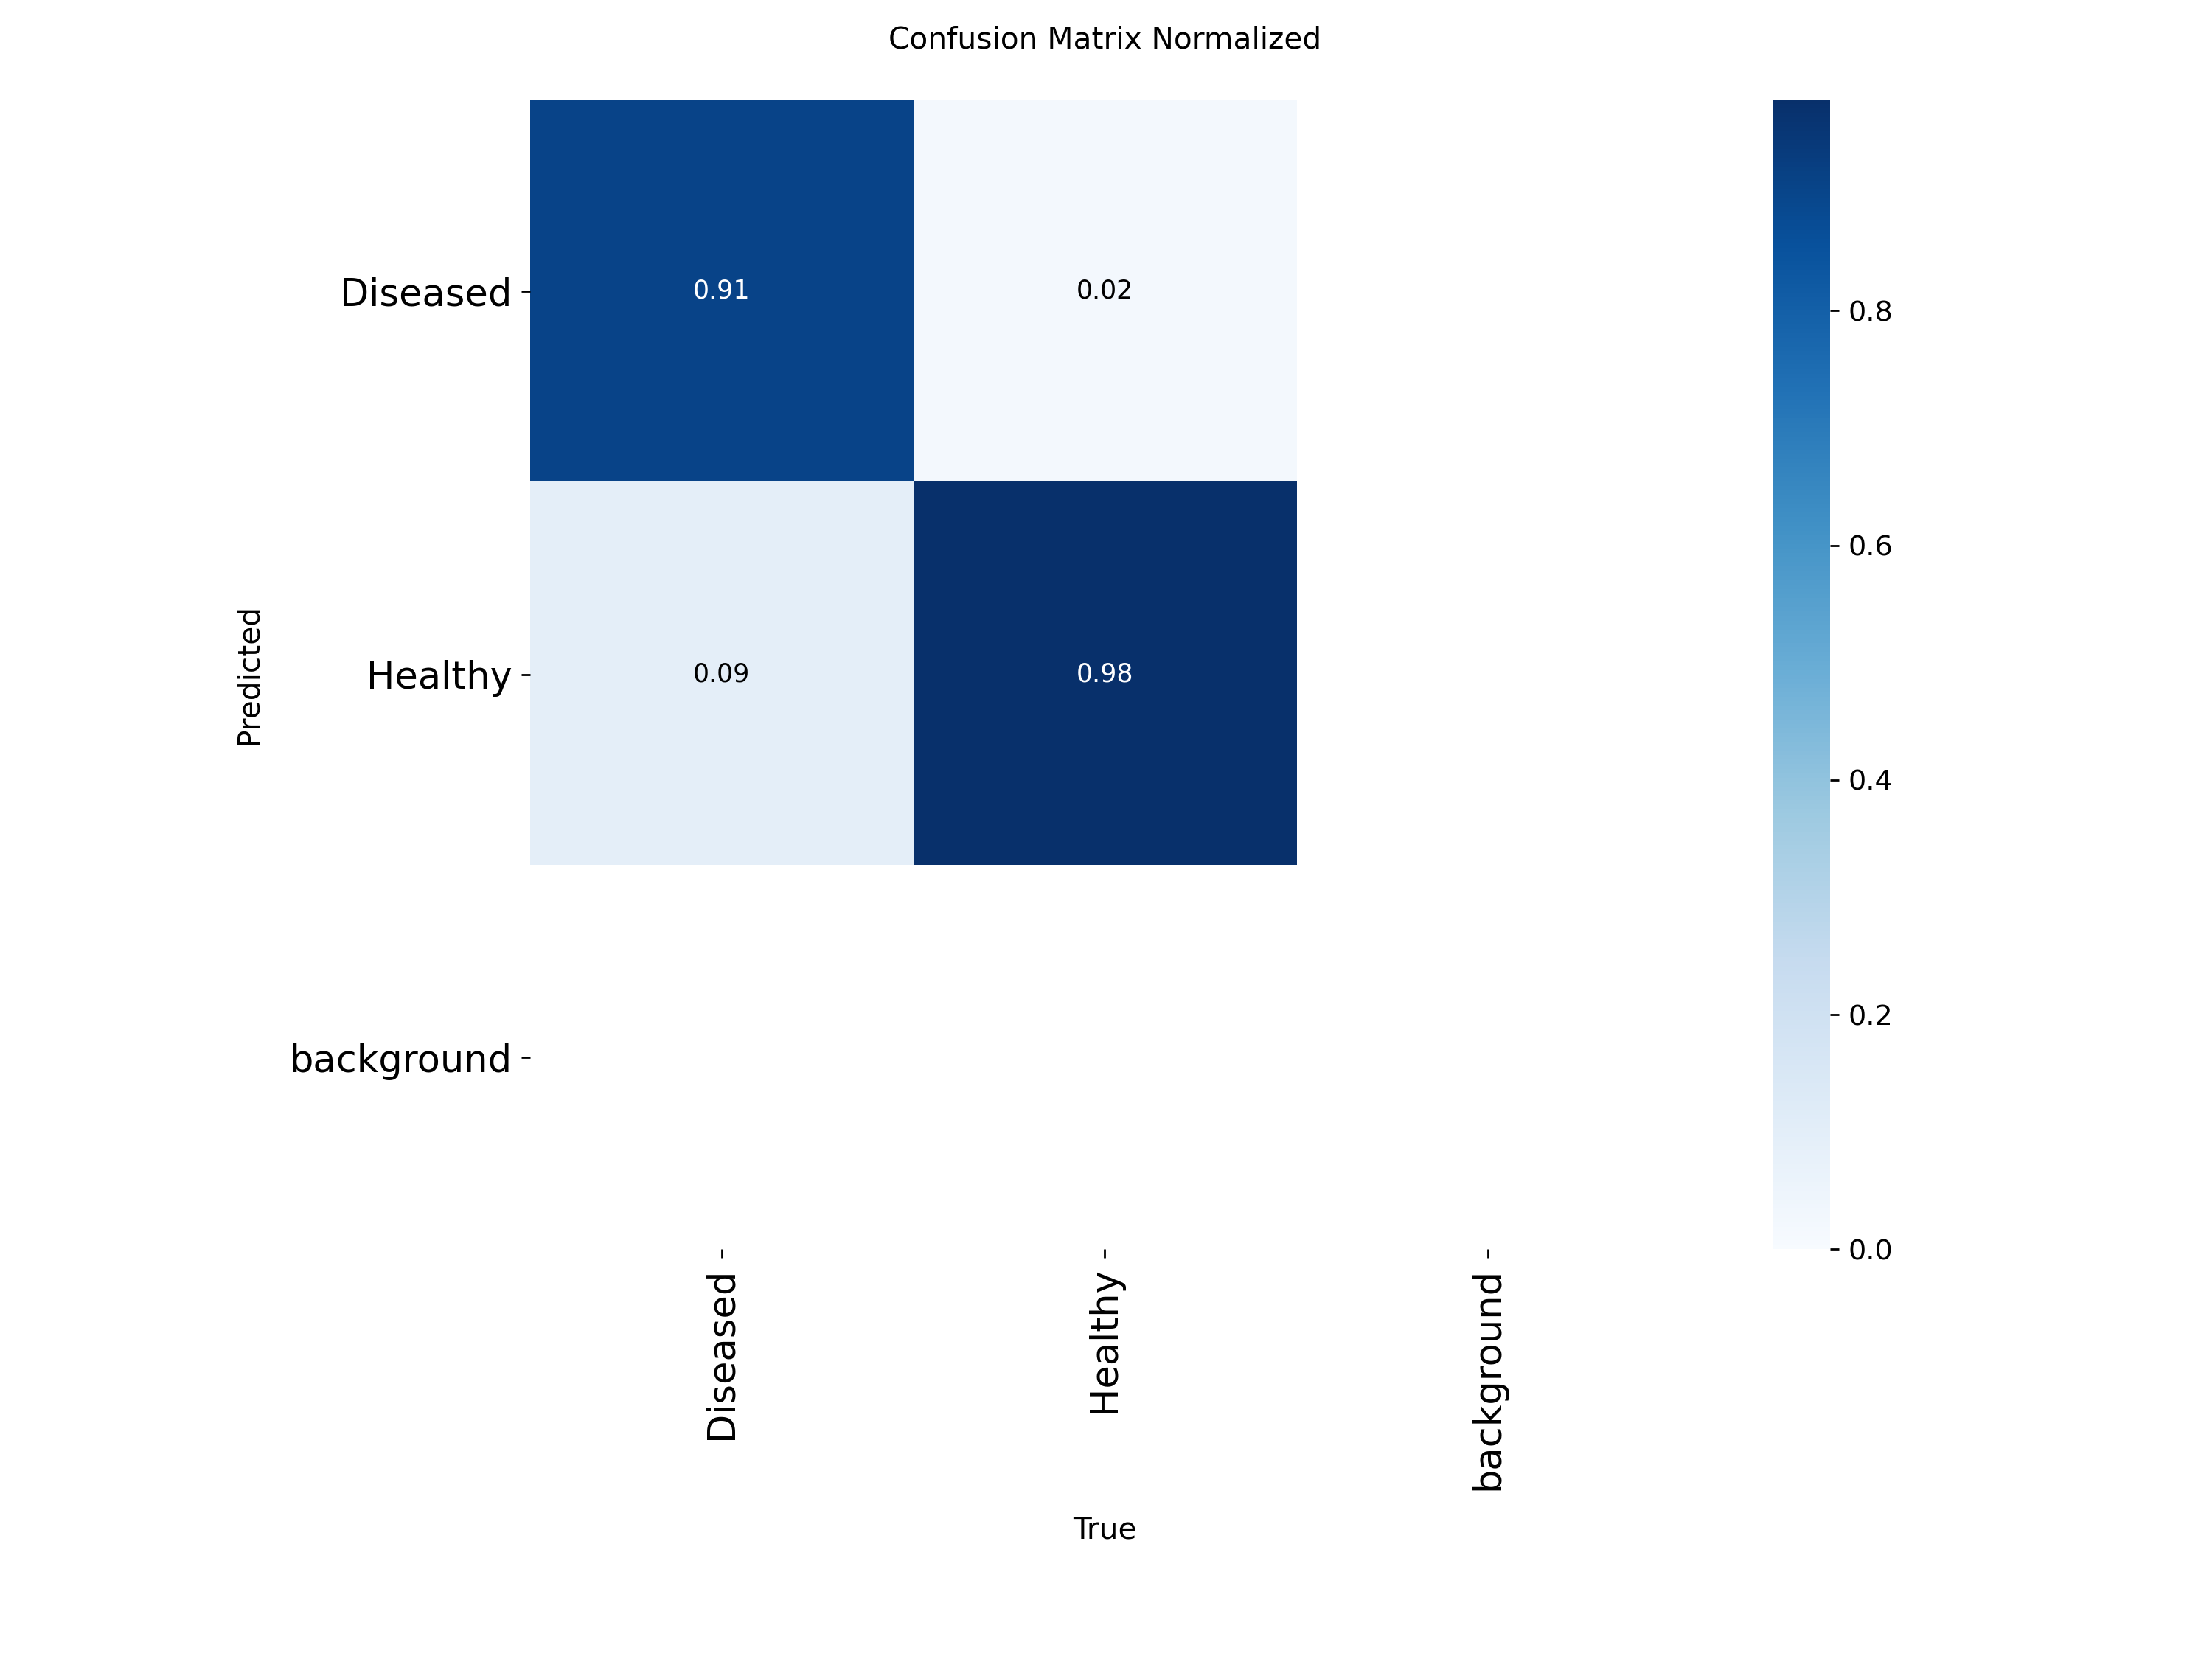

In [12]:
%matplotlib inline
from PIL import Image

Image.open('/content/drive/MyDrive/Plantify/runs/cls_baseline2/confusion_matrix_normalized.png')

Explanation:

We already evaluated our model earlier using YOLO’s built-in validation, which automatically generated the confusion matrix image inside our runs/cls_baseline2/ directory.
Now we simply display that PNG.


Our confusion matrix shows the model classifies 98% of healthy and 91% of diseased plants correctly, with minimal confusion between the two categories. Most errors involve diseased leaves being predicted as healthy, suggesting the model is slightly conservative in labeling disease. This could stem from uneven class variety or subtle disease symptoms. Overall, the baseline model performs strongly, achieving ~93% top-1 accuracy, with further fine-tuning likely to improve recall on diseased cases.

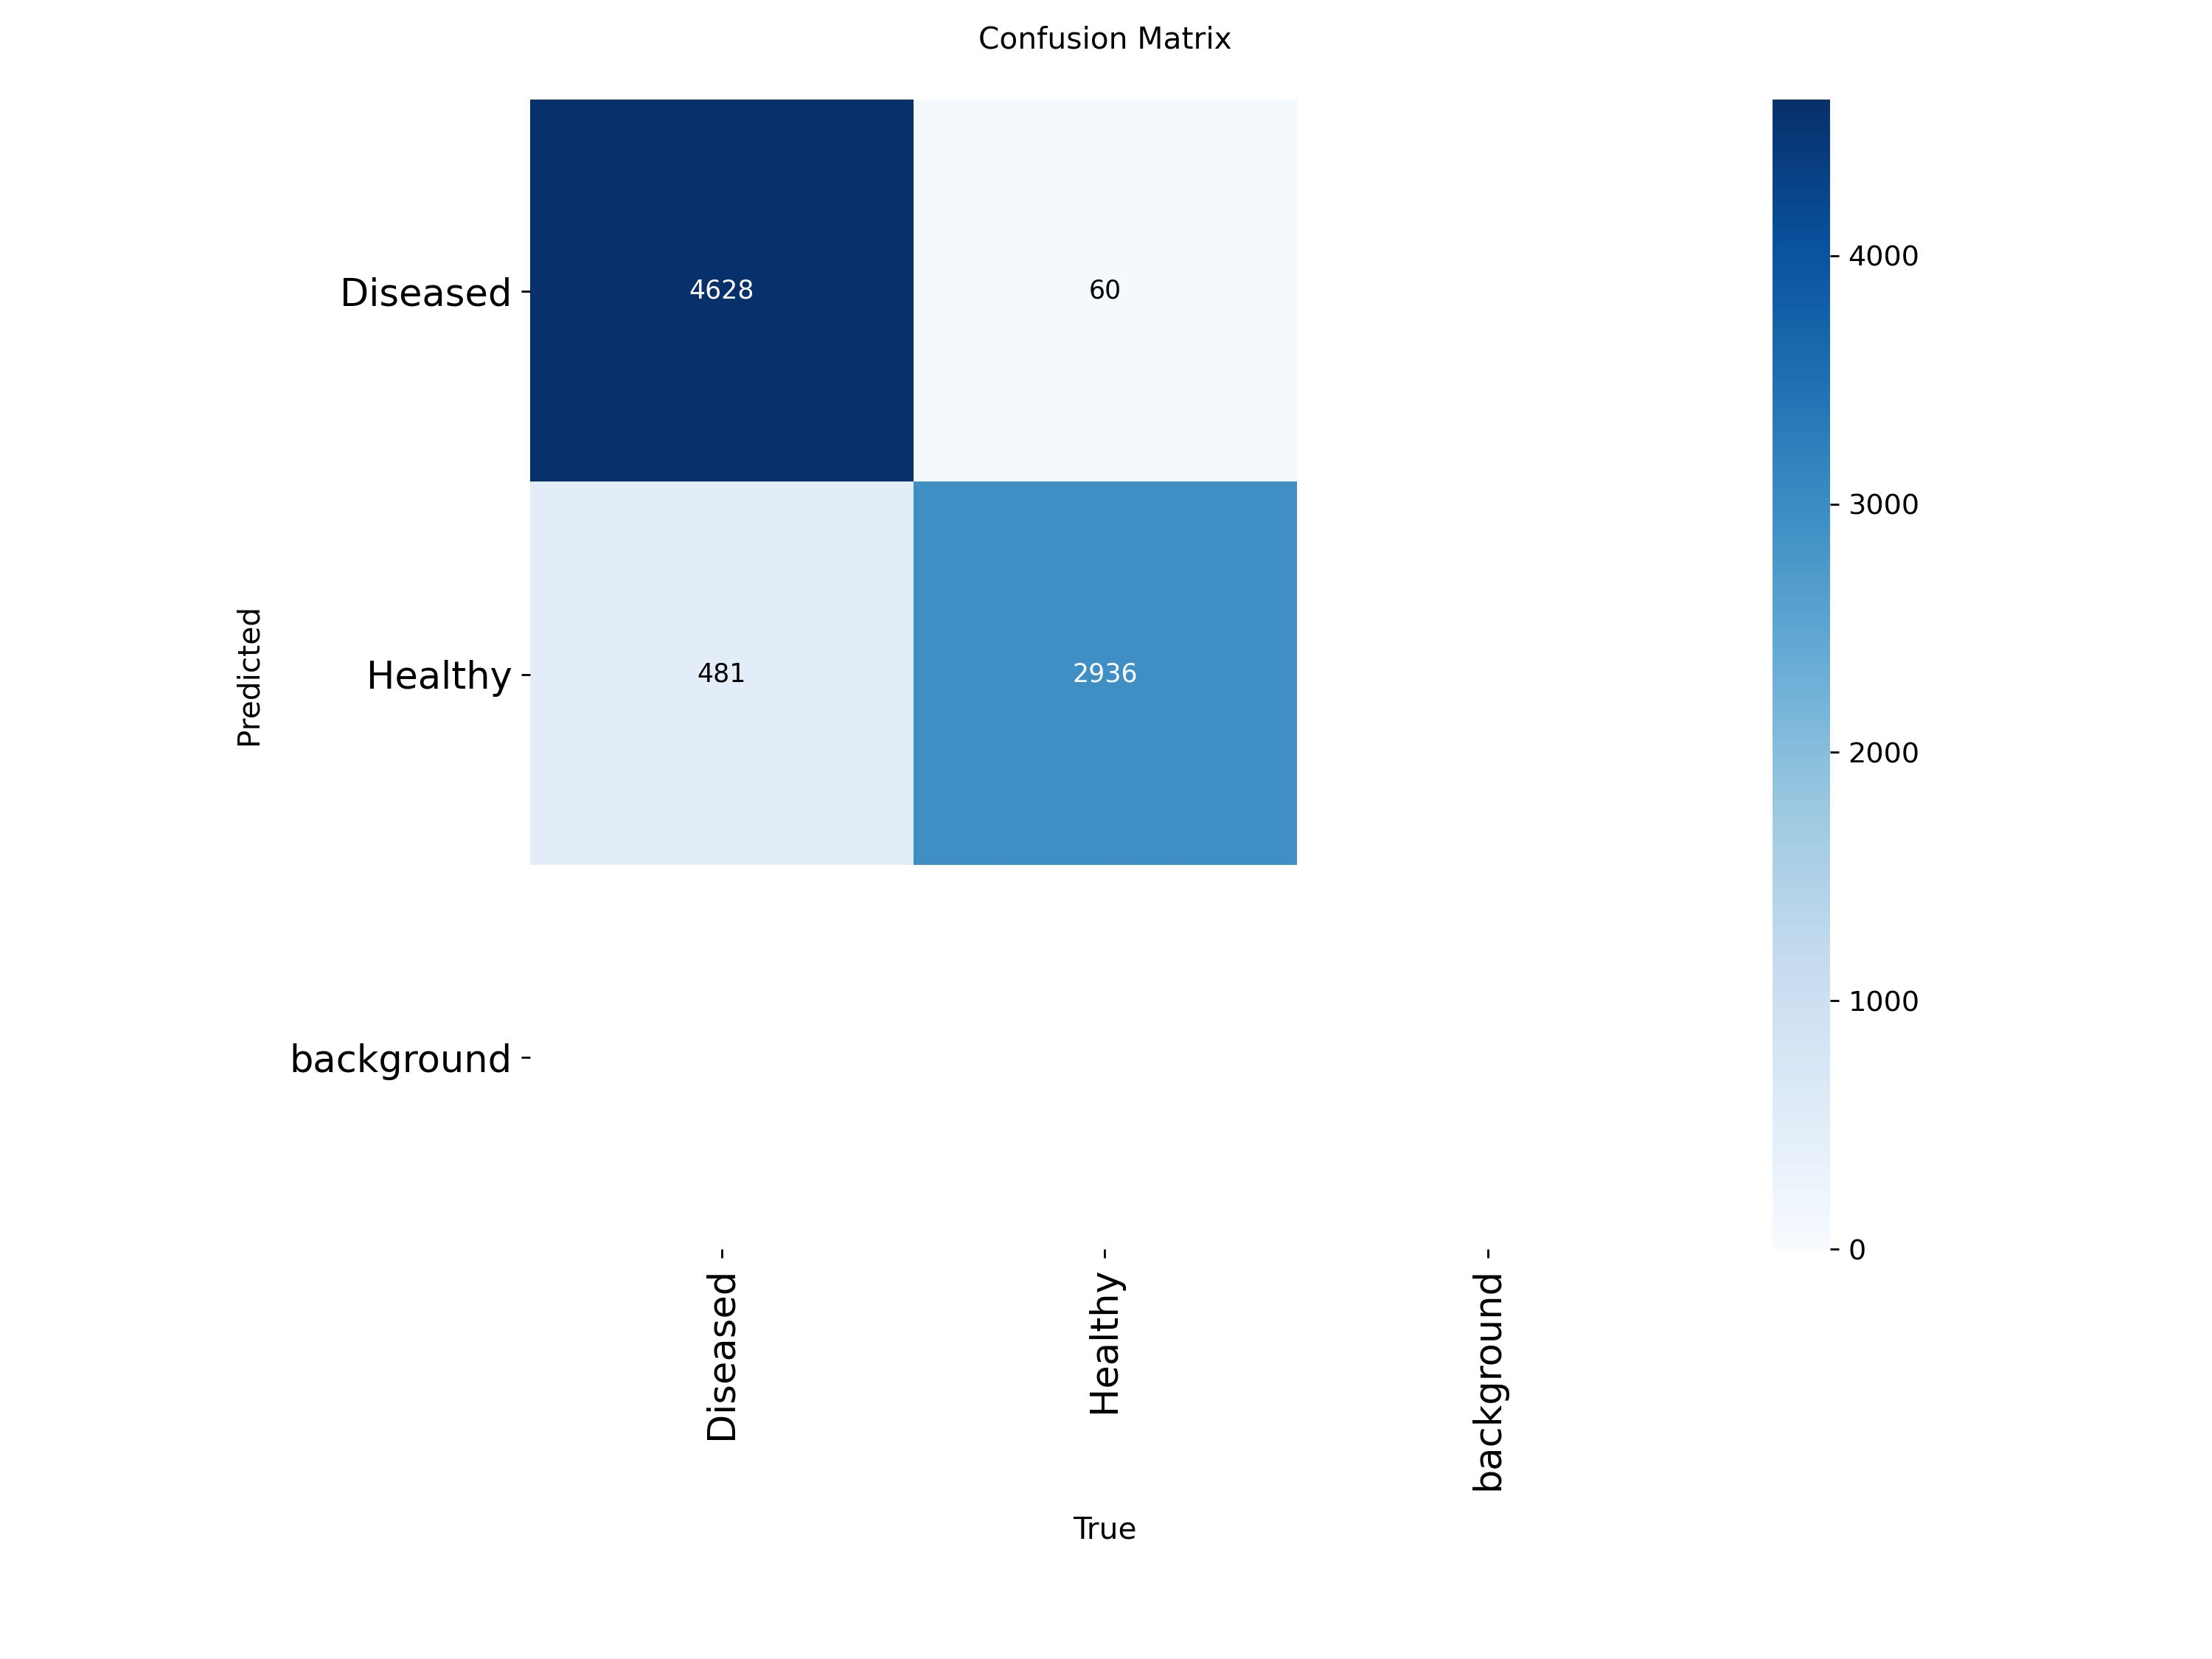

In [13]:
%matplotlib inline
from PIL import Image

Image.open('/content/drive/MyDrive/Plantify/runs/cls_baseline2/confusion_matrix.png')

We generated two versions of the confusion matrix to analyze model behavior both proportionally and numerically. The normalized version shows that the model correctly classified around 91% of diseased and 98% of healthy leaves, while the raw version shows the exact sample counts behind those percentages (4628 correct diseased, 2936 correct healthy, etc.). Together, these matrices helped us confirm our baseline accuracy of ~93% and identify that most errors came from misclassifying mild diseased samples as healthy.  